# Week 9: Clustering, GMM, PCA, and LDA

## Rasika Bhalerao

### Agenda:
- Make dataset
- KMeans clustering
 - Determing "good" clusters
- Agglomerative hierarchical clustering
 - Dendrograms
- GMMs
- LDA
 - Intuition / code
 - What to do with LDA
- PCA

Parts are based loosely off [notebooks by Cornelia Ilin](https://github.com/MIDS-W207/cilin-coursework/tree/master/live_sessions)

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import multivariate_normal
from sklearn import cluster, datasets, mixture
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import re
import zipfile
import gensim.downloader as api
from scipy.sparse import csr_matrix

In [2]:
# Create nice, clumpy dataset for clustering

X, y = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0)

for i in range(5):
  print(f'X: {X[i]} y: {y[i]}')

X: [2.60509732 1.22529553] y: 1
X: [0.5323772  3.31338909] y: 0
X: [0.802314   4.38196181] y: 0
X: [0.5285368  4.49723858] y: 0
X: [2.61858548 0.35769791] y: 1


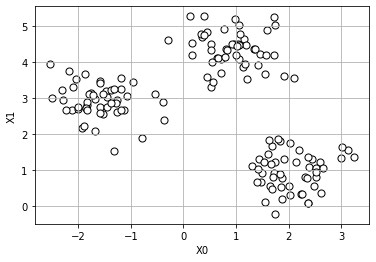

In [3]:
plt.scatter(X[:,0], X[:,1], c='white', marker='o', edgecolor='black', s=50);
plt.xlabel('X0')
plt.ylabel('X1')
plt.grid()

In [4]:
# KMeans clustering

n = 8

km = KMeans(
    n_clusters=n,
    # n_init=10,
    # max_iter=300,
    # tol=1e-04,
    # init='k-means++'
)

# fit the KMeans object and then predict class for each item in X
# The predicted class for each point is the one with a centroid closest to it
# Classes / clusters will be named 0, 1, 2, ..., n
y_km = km.fit_predict(X)

y_km

array([7, 2, 2, 6, 3, 5, 5, 3, 4, 5, 7, 0, 4, 2, 6, 4, 0, 3, 0, 3, 2, 7,
       2, 5, 0, 7, 7, 2, 4, 3, 4, 4, 0, 4, 6, 1, 7, 1, 2, 5, 0, 0, 6, 3,
       1, 7, 0, 5, 0, 5, 1, 6, 5, 3, 7, 0, 2, 7, 0, 5, 4, 0, 4, 0, 2, 0,
       5, 1, 6, 6, 2, 1, 7, 6, 1, 2, 5, 0, 0, 5, 1, 3, 2, 5, 1, 7, 7, 4,
       4, 3, 3, 2, 1, 6, 3, 5, 4, 4, 3, 1, 1, 7, 4, 3, 1, 5, 4, 5, 5, 6,
       0, 2, 1, 0, 5, 4, 5, 2, 0, 4, 2, 7, 6, 6, 1, 1, 0, 3, 4, 0, 0, 0,
       1, 0, 4, 0, 2, 4, 1, 4, 5, 2, 3, 7, 0, 4, 4, 0, 3, 3], dtype=int32)

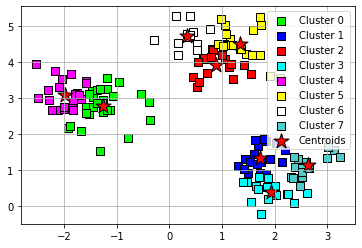

In [5]:
# Visualize the predicted classes

colors = [(0,1,0), (0,0,1), (1,0,0), (0,1,1), (1,0,1), (1,1,0), (1,1,1), (0.3,0.8,0.8)] # rgb tuples between 0 and 1

for i in range(n):
  plt.scatter(X[y_km == i, 0], # x coordinates of data points in cluster i
            X[y_km == i, 1],   # y coordinates of data points in cluster i
            s=50, color=colors[i],
            marker='s', edgecolor='black',
            label=f'Cluster {i}')
plt.scatter(km.cluster_centers_[:, 0], # x coordinates of centroids
            km.cluster_centers_[:, 1], # y coordinates of centroids
            s=250, marker='*',
            color='red', edgecolor='black',
            label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()

In [6]:
# How do we measure if these are "good" clusters?

print('within-cluster SSE: %.2f' % km.inertia_)

within-cluster SSE: 35.28


Text(0, 0.5, 'within-cluster SSE')

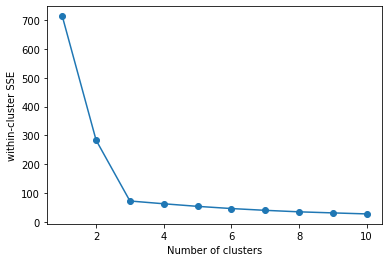

In [7]:
# Within cluster SSE for different values of k

wc_SSE = [KMeans(n_clusters=k).fit(X).inertia_ for k in range(1,11)]

plt.plot(range(1,11), wc_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('within-cluster SSE')

Why not just use the k with the smallest within-cluster SSE?

### Agglomerative Clustering

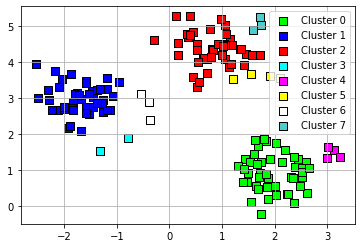

In [8]:
n = 8

ac = AgglomerativeClustering(n_clusters=n,
                             affinity='euclidean',
                             linkage='average')
y_ac = ac.fit_predict(X)

for i in range(n):
  plt.scatter(X[y_ac == i, 0],
            X[y_ac == i, 1],
            s=50, color=colors[i],
            marker='s', edgecolor='black',
            label=f'Cluster {i}')

plt.legend(scatterpoints=1)
plt.grid()

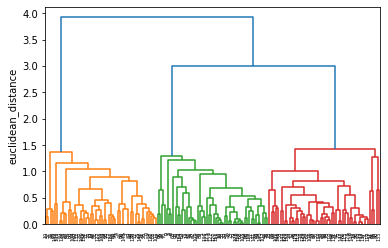

In [9]:
clusters = linkage(
    pdist(
        pd.DataFrame(X)
    ),
    method='average'
)
row_dendr = dendrogram(clusters, labels=[str(i) for i in range(len(X))])
plt.ylabel('euclidean_distance');

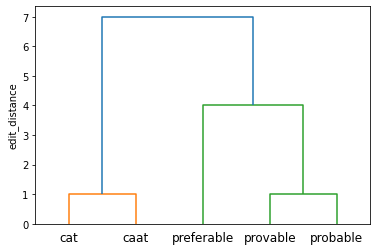

In [11]:
# !pip install python-Levenshtein
from Levenshtein import distance

dataset = [
           'provable',
           'probable',
           'preferable',
           'cat',
           'caat'
]

def levenshtein_distance(idx1, idx2):
  return distance(dataset[idx1[0]], dataset[idx2[0]])

clusters = linkage(
    pdist(
        [[i] for i in range(len(dataset))],
        metric=levenshtein_distance
    ),
    method='single'
)
row_dendr = dendrogram(clusters, labels=dataset)
plt.ylabel('edit_distance');

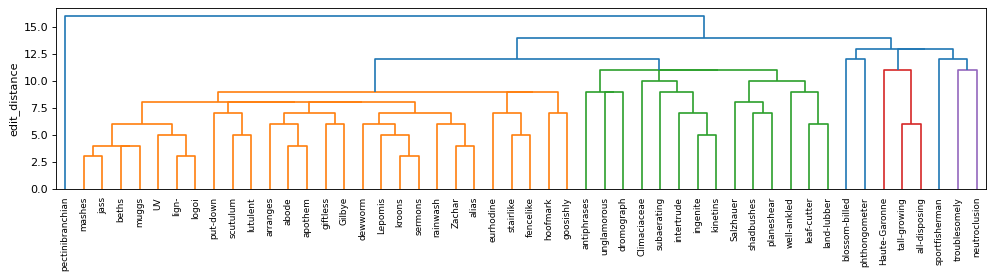

In [12]:
# !pip install python-Levenshtein
from Levenshtein import distance

dataset = random.sample([word.strip() for word in open('words_alpha.txt', 'r').readlines()], 50)

def levenshtein_distance(idx1, idx2):
  return distance(dataset[idx1[0]], dataset[idx2[0]])

clusters = linkage(
    pdist(
        [[i] for i in range(len(dataset))],
        metric=levenshtein_distance
    ),
    method='complete'
)

plt.figure(figsize=(15, 3), dpi=80)
row_dendr = dendrogram(clusters, labels=dataset)
plt.ylabel('edit_distance');

### GMMs

In [13]:
def gauss_pdf(data, mean:float, variance:float):
    """ 1-D gaussian distribution equation
    (see formula here: https://en.wikipedia.org/wiki/Normal_distribution)
    # param data: np.array
    # param mean: float point
    # param variance: float point
    # return gauss_pdf: np.array, float points
    """
    s1 = 1/(np.sqrt(2*np.pi*variance))
    s2 = np.exp(-(np.square(data - mean)/(2*variance)))
    
    # compute pdf
    pdf = s1 * s2
    
    return pdf


n_samples = 100
mu1, sigma1 = -4, 1.2
mu2, sigma2 = 0, 1.6 

c1 = np.random.normal(mu1, np.sqrt(sigma1), n_samples)
c2 = np.random.normal(mu2, np.sqrt(sigma2), n_samples)

C = np.array(list(c1) + list(c2))

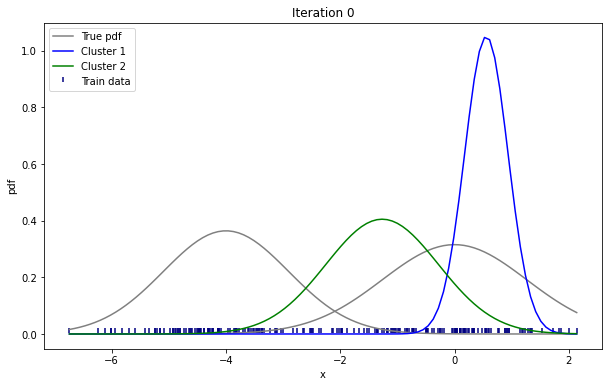

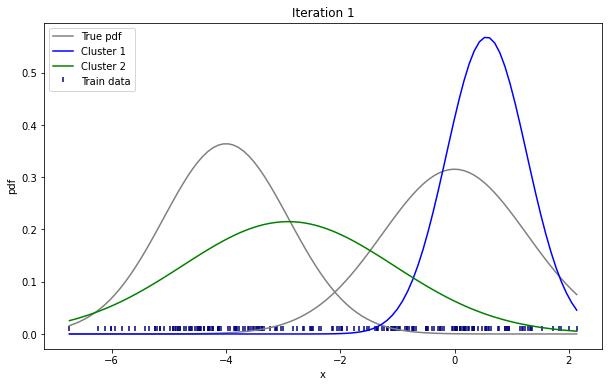

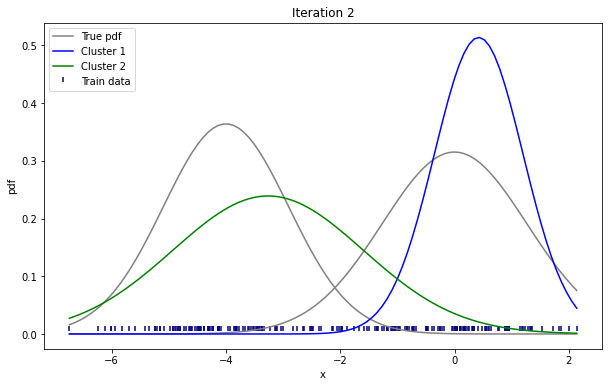

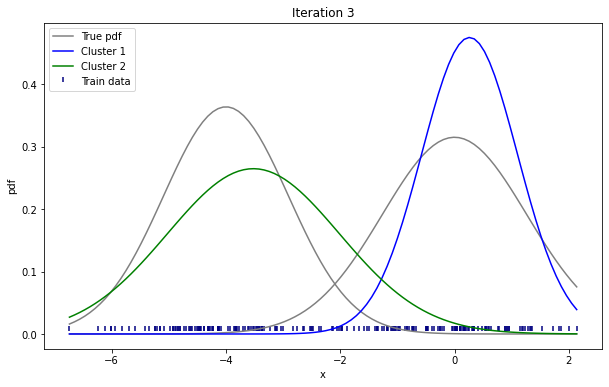

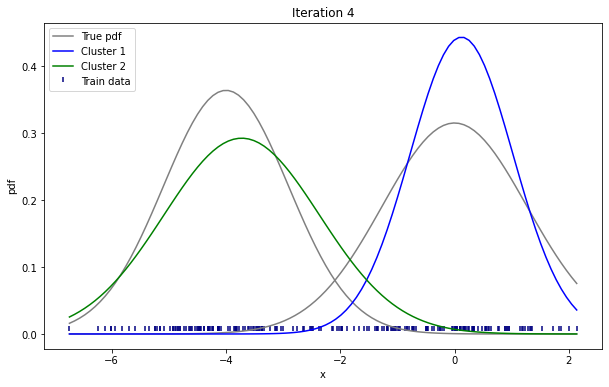

In [14]:
k = 2
weights = np.ones((k)) / k
means = np.random.choice(C, k)
variances = np.random.random_sample(size=k)
eps=1e-8
bins = np.linspace(np.min(C), np.max(C), 100)

for iteration in range(5):
    
    if iteration % 1 == 0:
        plt.figure(figsize=(10,6))

        
        # plot C data
        plt.title("Iteration {}".format(iteration))
        plt.scatter(C, [0.005] * len(C), color='navy', s=30, marker=2, label="Train data")
        
        # plot true pdf
        plt.plot(bins, gauss_pdf(bins, mu1, sigma1), color='grey', label="True pdf")
        plt.plot(bins, gauss_pdf(bins, mu2, sigma2), color='grey')
        
        # plot estimated pdf
        plt.plot(bins, gauss_pdf(bins, means[0], variances[0]), color='blue', label="Cluster 1")
        plt.plot(bins, gauss_pdf(bins, means[1], variances[1]), color='green', label="Cluster 2")
        
        # add labels and legend
        plt.xlabel("x")
        plt.ylabel("pdf")
        plt.legend(loc='upper left')
  
    ## the Expectation step
    # calculate the likelihood of each observation ci
    likelihood = []
  
    for j in range(k):
        likelihood.append(gauss_pdf(C, means[j], np.sqrt(variances[j])))
    likelihood = np.array(likelihood)
    
    # calculate the likelihood that each observation ci belongs to cluster j
    b = []
 
    for j in range(k):
        # use the current values for the parameters to evaluate the posterior
        # probabilities of the data to have been generanted by each gaussian    
        b.append((likelihood[j] * weights[j]) / (np.sum([likelihood[i] * weights[i] for i in range(k)], axis=0)+eps))
    
        ## The Maximization step
        
        # updage mean and variance
        means[j] = np.sum(b[j] * C) / (np.sum(b[j] + eps))
        variances[j] = np.sum(b[j] * np.square(C - means[j])) / (np.sum(b[j] + eps))

        # update the weights
        weights[j] = np.mean(b[j])

### LDA

Latent Dirichlet Allocation (LDA)

- Finds distributions of latent topics in a set of documents
 - A "topic" is a probability distribution of words
 - Each document will get a distribution of topics
- Topics are latent because they are not directly observed in the documents
 - (They are used to explain the words, which are directly observed)
- Documents and words each follow Dirichlet distributions because they are distributions of distributions

In [15]:
df = pd.DataFrame({
    'document': [
        'whiskers tail tail paw purr',
        'meow whiskers whiskers',
        'meow meow paw purr',
        'paw bark woof bark',
        'paw paw bark bark'
    ]
})

df.head()

,document
0,whiskers tail tail paw purr
1,meow whiskers whiskers
2,meow meow paw purr
3,paw bark woof bark
4,paw paw bark bark


In [16]:
topics = 2
vec = CountVectorizer()
X = vec.fit_transform(df['document'])
lda = LatentDirichletAllocation(n_components=topics)
doc_topics = lda.fit_transform(X)
doc_topics

array([[0.88013407, 0.11986593],
       [0.85669381, 0.14330619],
       [0.27605457, 0.72394543],
       [0.10445637, 0.89554363],
       [0.1054871 , 0.8945129 ]])

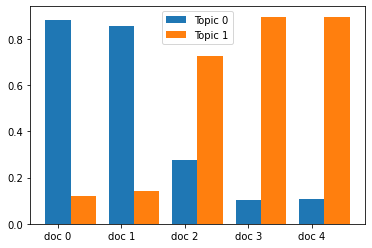

In [17]:
for topic in range(topics):
  plt.bar(
      [i + topic*0.8/topics for i in range(len(doc_topics))],
      [i[topic] for i in doc_topics],
      width=0.8/topics,
      label=f'Topic {topic}'
  )
plt.xticks(range(len(doc_topics)), [f'doc {i}' for i in range(len(doc_topics))])
plt.legend()
plt.show()

In [18]:
topic_words = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
topic_words

array([[0.0426421 , 0.14531371, 0.11894834, 0.14757422, 0.20945045,
        0.29345882, 0.04261235],
       [0.29754456, 0.15038239, 0.3036277 , 0.08236912, 0.03359527,
        0.03360723, 0.09887373]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


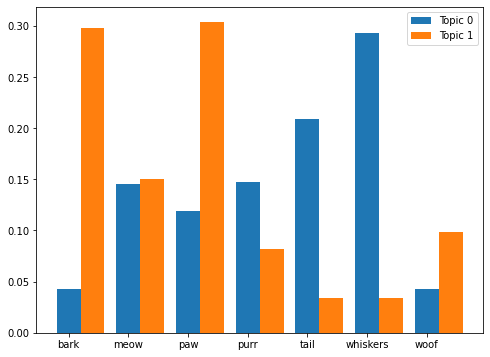

In [19]:
words = vec.get_feature_names()
plt.figure(figsize=(8, 6))
for topic in range(topics):
  plt.bar(
      [i + topic*0.8/topics for i in range(len(words))],
      topic_words[topic],
      width = 0.8/topics,
      label=f'Topic {topic}'
  )
plt.xticks(range(len(words)), words)
plt.legend()
plt.show()

LDA Algorithm

- Pick k - the number of topics
- Compile a vocabulary from the documents
- Randomly assign each word in the vocabulary to a topic
- Until all document distributions converge:
 - For each document d:
   1. For each word w in d, for each topic t:
     - Calculate P(t | d): percent of other words (not w) in d that are in t
     - Calculate P(w | t): percent of other documents (not d) that have word w
   2. Repeat step 1 until document d’s distribution converges
 - Update the probability of word w belonging to topic t: P(w | t) = P(t |d) * P(w | t)

 ### What to do with LDA?

In [20]:
# Analyze the major "themes" (topics) in the corpus
# Analyze the distribution of topics for each document
# Analyze important words for each topic

df = pd.DataFrame({
    'document': [
        'Your cat purrs and has fur.',
        'My cat meows and purrs.',
        'Your cat dislikes oranges.',
        'Oranges are citrus fruits.',
        'Oranges are fruits with Vitamin C.'
    ]
})

df.head()

,document
0,Your cat purrs and has fur.
1,My cat meows and purrs.
2,Your cat dislikes oranges.
3,Oranges are citrus fruits.
4,Oranges are fruits with Vitamin C.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


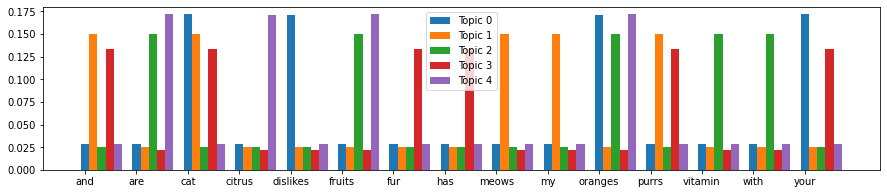

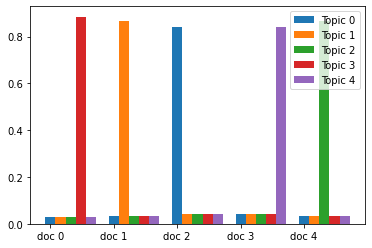

In [21]:
topics = 5
vec = CountVectorizer()
X = vec.fit_transform(df['document'])
lda = LatentDirichletAllocation(n_components=topics)
doc_topics = lda.fit_transform(X)
topic_words = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
words = vec.get_feature_names()
plt.figure(figsize=(15, 3))
for topic in range(topics):
  plt.bar(
      [i + topic*0.8/topics for i in range(len(words))],
      topic_words[topic],
      width = 0.8/topics,
      label=f'Topic {topic}'
  )
plt.xticks(range(len(words)), words)
plt.legend()
plt.show()
for topic in range(topics):
  plt.bar(
      [i + topic*0.8/topics for i in range(len(doc_topics))],
      [i[topic] for i in doc_topics],
      width=0.8/topics,
      label=f'Topic {topic}'
  )
plt.xticks(range(len(doc_topics)), [f'doc {i}' for i in range(len(doc_topics))])
plt.legend()
plt.show()


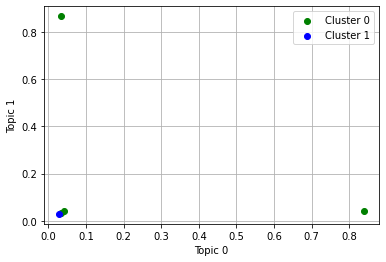

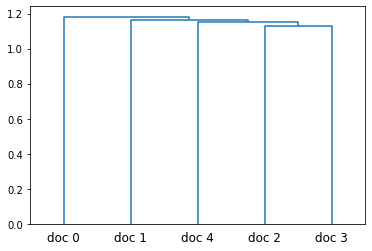

In [22]:
# Get the LDA vector for each document and use these vectors to cluster documents
# Or use LDA vectors as the features for each document and use them for supervised methods

n=2
clustering = AgglomerativeClustering(n_clusters=n).fit_predict(doc_topics)
colors = ['green', 'blue', 'turquoise', 'lightgreen', 'grey', 'lightblue', 'white', 'lightgrey']
for i in range(n):
  plt.scatter(
      doc_topics[clustering == i, 0],
      doc_topics[clustering == i, 1],
      c=colors[i],
      label=f'Cluster {i}')
plt.xlabel('Topic 0')
plt.ylabel('Topic 1')
plt.legend()
plt.grid()
plt.show()

clusters = linkage(
    pdist(
        pd.DataFrame(doc_topics)
    ),
    method='average'
)
row_dendr = dendrogram(clusters, labels=[f'doc {i}' for i in range(len(doc_topics))])

# You can also use Bag of words vectors for supervised/unsupervised tasks,
# and weight each word by how likely it is to be in a certain topic according to LDA

### PCA

In [23]:
# Dataset: word2vec embeddings learned from newspapers

corpus = [sentence['data'] for sentence in api.load('20-newsgroups')]
corpus = [
          [re.sub(r'\W+', '', word) for word in sentence.strip().split()]
          for sentence in corpus
]
corpus = [[word for word in sentence if len(word) > 0] for sentence in corpus]
vocab = list(set(word for sentence in corpus for word in sentence))

w2v = Word2Vec(sentences=corpus, size=50, window=5, min_count=1, workers=-1)

[==================================================] 100.1% 13.8/13.8MB downloaded


In [24]:
# Look at the vector for the word 'about'
w2v.wv['about']

array([ 5.4823859e-03,  2.7658876e-03, -9.6715754e-03, -2.9787007e-03,
       -6.9320435e-03,  8.0823908e-03,  5.2758344e-03, -6.2024798e-03,
        9.5966384e-03, -3.6617045e-03,  5.3780149e-03, -6.9304006e-03,
        1.2949797e-03,  2.4832166e-06, -2.3118693e-03, -5.5675199e-03,
        7.6401951e-03, -4.3044887e-03, -1.4385382e-03, -7.9469858e-03,
        4.1191126e-03, -6.3554884e-04,  8.9682369e-03,  6.2698754e-04,
       -6.7598308e-03,  4.5992928e-03, -2.3821073e-04, -3.1925510e-03,
        2.4270460e-03, -8.4489360e-03, -8.5819270e-03,  3.6062482e-03,
        1.6509003e-03,  8.9621264e-03, -7.0411279e-03,  1.7997705e-03,
        1.6156633e-03, -5.5153477e-03, -6.1162533e-03, -1.7188023e-03,
        9.3083661e-03,  5.7560378e-03, -6.4219735e-03, -6.0377447e-03,
       -9.0863984e-03,  2.5771006e-03,  8.5102033e-04,  9.2096701e-03,
       -2.1215323e-03, -1.9550060e-03], dtype=float32)

In [25]:
# Do PCA on all the word vectors
X = [w2v.wv[word] for word in vocab]
pca = PCA()
transformed = pca.fit_transform(X)
transformed[0]

array([-7.34013499e-03, -3.74914242e-03, -6.80544535e-03,  1.87290929e-04,
       -9.23849514e-03, -9.58160063e-05,  6.02176910e-03, -3.85053307e-03,
        5.14262979e-05, -4.68019088e-03, -8.18826806e-03,  5.00998247e-04,
        1.10063929e-02,  3.98784089e-03,  5.70606024e-03, -9.67580312e-03,
       -2.30716392e-03, -4.58521905e-03, -2.03531374e-03, -7.09073570e-03,
        7.95873345e-03,  1.11017273e-02, -1.10384803e-02,  1.50301608e-03,
       -8.72699978e-03,  2.98329617e-03,  4.98602837e-03,  8.73429482e-03,
        1.62361139e-03, -8.09036858e-03, -1.22030933e-03, -7.69281269e-03,
        4.16505835e-03, -6.88195123e-03,  9.37171390e-04, -6.89307821e-03,
       -2.61801275e-03, -6.13521142e-03,  2.07497727e-03, -1.34690967e-03,
       -1.63565496e-03, -3.15617133e-03,  2.15684347e-03, -9.39891687e-04,
        1.79884453e-03,  4.45643518e-03, -4.68906050e-03,  1.75030718e-04,
       -4.22938272e-03, -1.47277123e-04])

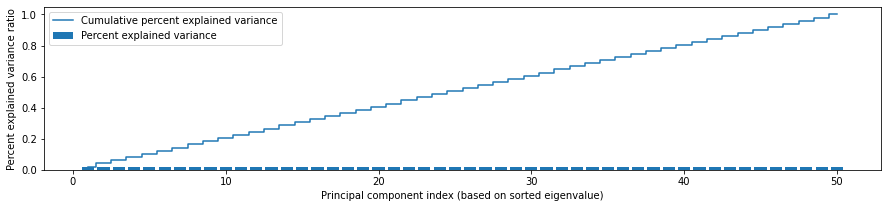

In [26]:
# What percent of the variance is explained by the first n dimensions?

dimensions = range(1,51)
percent_variance = pca.explained_variance_ratio_

plt.figure(figsize=(15, 3))
plt.bar(dimensions, percent_variance, label='Percent explained variance')
plt.step(dimensions, np.cumsum(percent_variance), where='mid', label='Cumulative percent explained variance')
plt.legend()
plt.ylabel('Percent explained variance ratio');
plt.xlabel('Principal component index (based on sorted eigenvalue)');

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


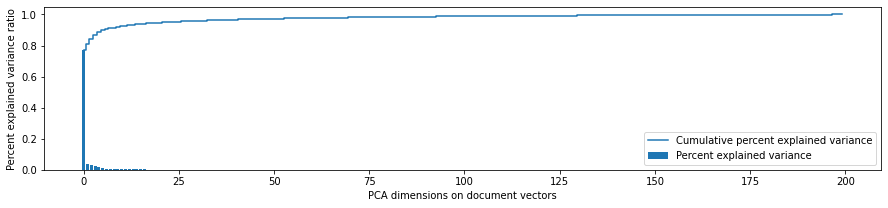

In [27]:
# Now let's try doing PCA on the document vectors

vec = CountVectorizer(max_features=200)
X = vec.fit_transform([' '.join(sentence) for sentence in corpus])

pca = PCA()
transformed = pca.fit_transform(csr_matrix.todense(X))
percent_variance = pca.explained_variance_ratio_
plt.figure(figsize=(15, 3))
plt.bar(range(len(vec.vocabulary_)), percent_variance, label='Percent explained variance')
plt.step(range(len(vec.vocabulary_)), np.cumsum(percent_variance), where='mid', label='Cumulative percent explained variance')
plt.legend()
plt.ylabel('Percent explained variance ratio');
plt.xlabel('PCA dimensions on document vectors')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


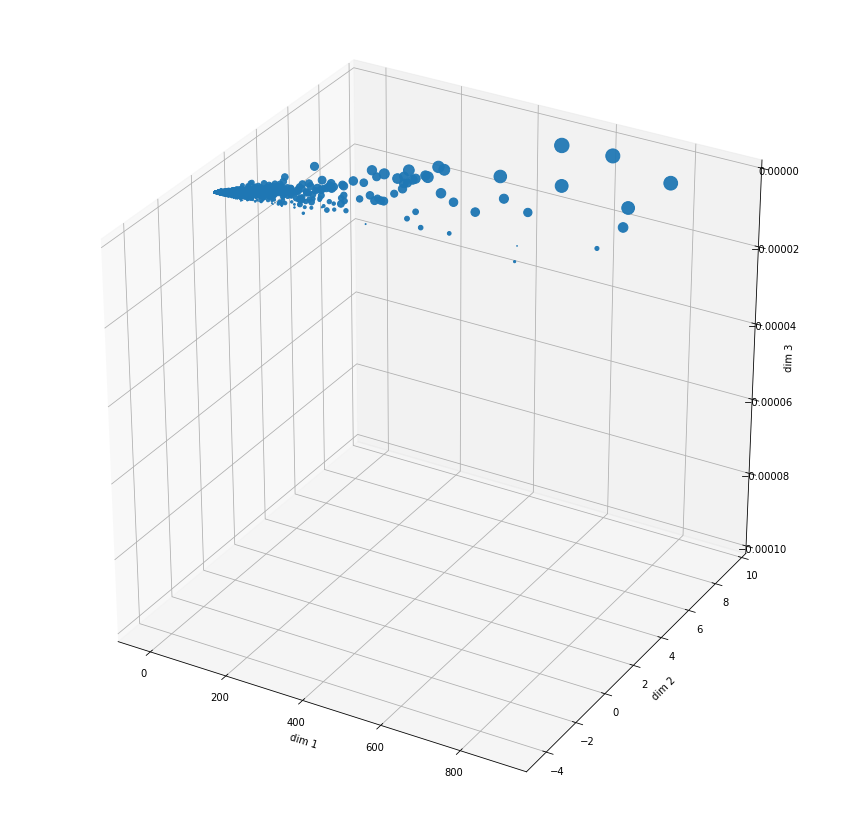

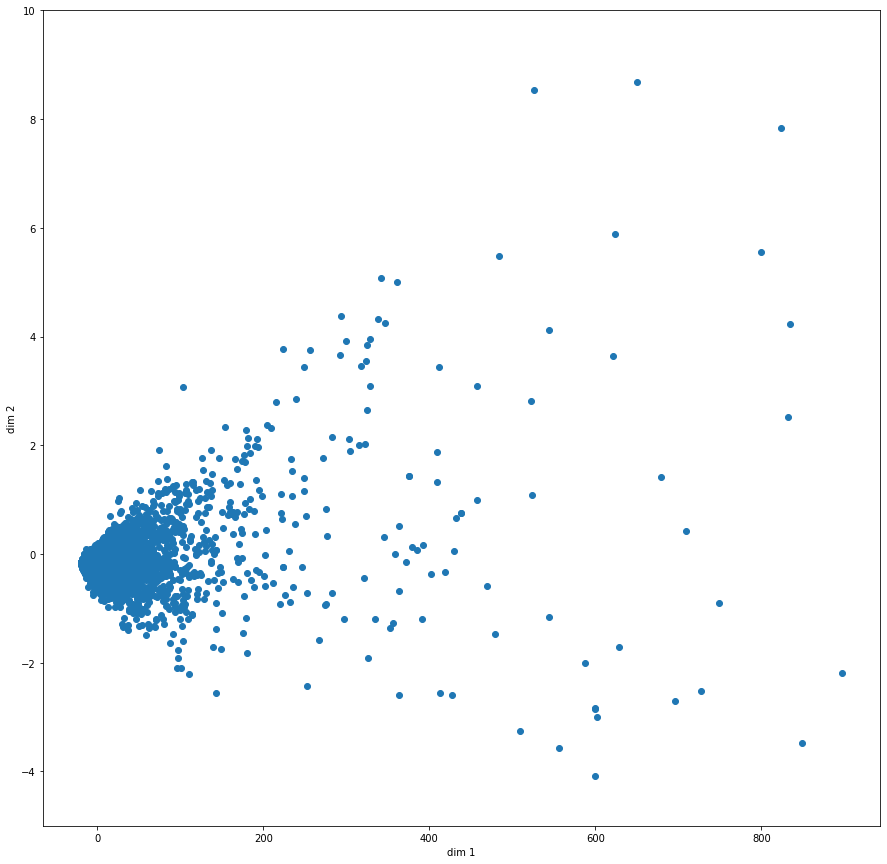

In [28]:
pca = PCA(n_components=3)
transformed = pca.fit_transform(csr_matrix.todense(X))
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
ax.set_ylim([-5,10])
ax.set_zlim([-0.0001,0])
plt.scatter([i[0] for i in transformed], [i[1] for i in transformed], [i[2] for i in transformed])
ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('dim 3')
plt.show()

plt.figure(figsize=(15, 15))
plt.scatter([i[0] for i in transformed], [i[1] for i in transformed])
plt.ylim([-5,10])
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()